# Problem 6: Regression techniques

    In this problem we use the same data set on service usage of 1000 clients of a telecommunication company as in Assignment 3. The variable tenure is taken as the dependent variable and the remaining variables as explanatory.

In [97]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import r2_score
import lmfit
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

df_telco = pd.read_csv('telco.txt', sep='\t')
df_telco.head()

np.random.seed(42)

In [98]:
ed_names = {
    'College degree': 'ed_college',
    'Did not complete high school': 'ed_no',
    'High school degree': 'ed_high',
    'Post-undergraduate degree': 'ed_undergrad',
    'Some college': 'ed_some_college'
}

ed_dummy = pd.get_dummies(df_telco['ed'])
ed_dummy = ed_dummy.rename(columns=ed_names).drop(['ed_no'], 1)

df_telco_dummies = pd.concat([df_telco.drop('ed', 1), ed_dummy], 1)
df_telco_dummies['marital'] = df_telco_dummies['marital'].map(dict(Married=1, Unmarried=0))
df_telco_dummies['retire'] = df_telco_dummies['retire'].map(dict(Yes=1, No=0))
df_telco_dummies['gender'] = df_telco_dummies['gender'].map(dict(Male=1, Female=0))
df_telco_dummies['churn'] = df_telco_dummies['churn'].map(dict(Yes=1, No=0))

df = df_telco_dummies.copy()
df['log_longmon'] = np.log(df['longmon'])
df['log_income'] = np.log(df['income'])
df['log_tenure'] = np.log(df['tenure'])
df = df[df['wiremon'] != 0]

dependent_variable = 'log_tenure'
explan_variables = [
    'age', 'marital', 'address', 'log_income',
    'employ', 'retire','gender', 'log_longmon',
    'wiremon', 'churn', 'ed_college', 
    'ed_high', 'ed_undergrad', 'ed_some_college'
]

X, y = df[explan_variables], df[dependent_variable]

## Part 1: Lasso Regression

> The lasso regression is an alternative approach to variable selection.

1. Explain in your own words the idea of the lasso regression. Sketch a situation when a simple linear regression fails, but the lasso regression still can be estimated.

    Idea behind lasso regression is behind additional regularization of parameters. In case of lasso regression, we penalty model for high variability of slope coefficients by minimizing sum of absolute values of slope coefficients. In case of ridge regression, we are trying to minimize sum of squared slope coefficients. 
    
    To fit linear regression, we need number of observations not less, than number of features. If it is more than, then we will have space of solutions with > 2 dimensions. But with lasso regression, we can estimate it even with low amount of observations.

2. For the usual regression model the variables are rarely normalized/standardized. However, in the case of the lasso regression the scaling becomes crucial. Why? Scale your data by $(x_i - \overline{x})/\hat{\sigma_i}$. Can/should the binary variables be scaled in the same fashion? How would you handle the variable **ed**?

    In case of lasso regression, we need to scale variables, so that regularization is more evenly distributed between all of the regressors. Binary and dummy variables should be scaled too.

In [3]:
X = (X - X.mean())/X.std()

3. Run a lasso regression for data with $\alpha \in (0; 1)$. Plot the estimated parameters as functions of $\alpha$. Which value of $\alpha$ would you recommend? If it is easy to implement, then determine the optimal $\lambda$ by cross-validation.

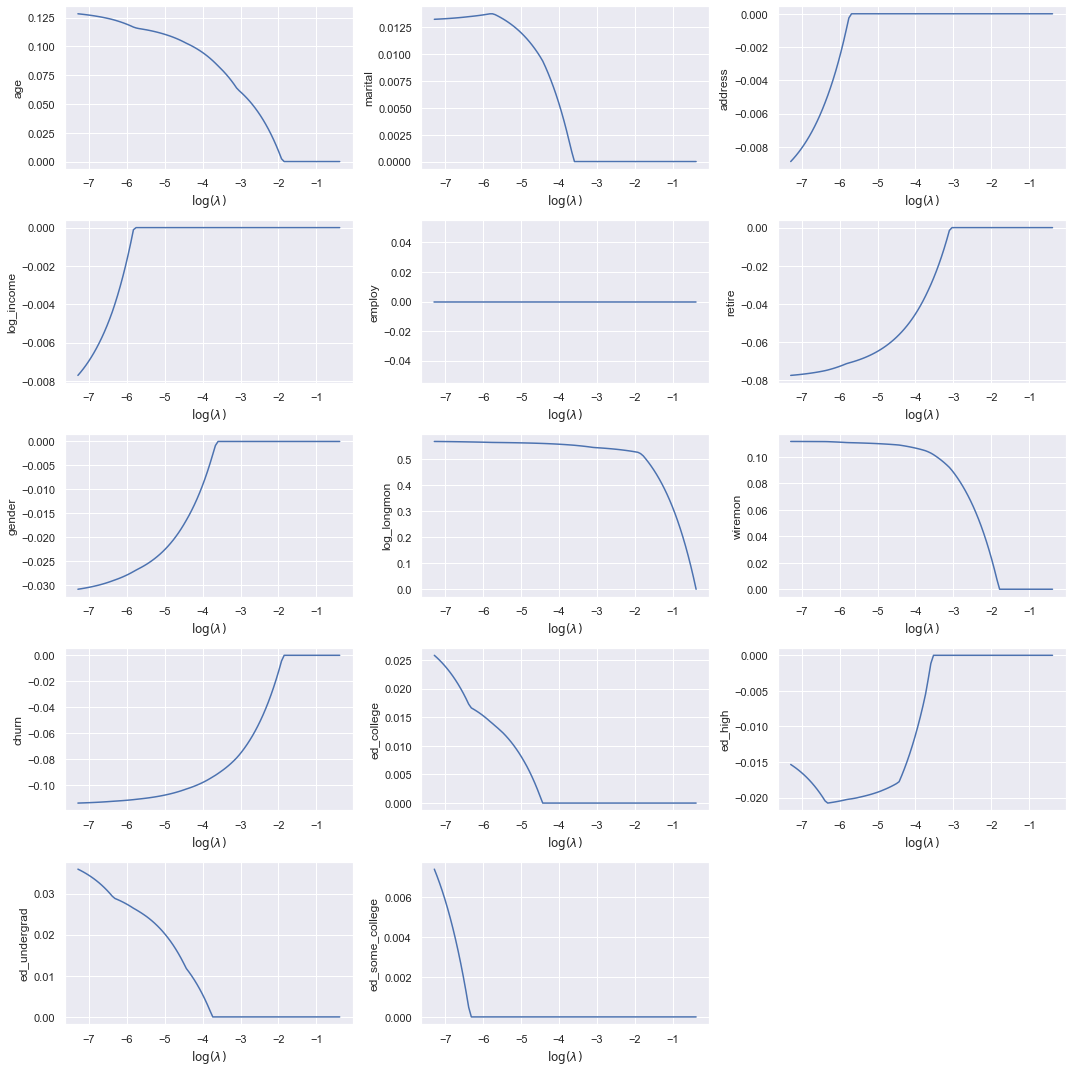

In [4]:
from sklearn.linear_model import LassoCV

k_folds = 10
seed = 42
alphas = np.linspace(0, 1, 20)

params = [None] * alphas.size

reg = LassoCV(cv=k_folds, random_state=seed)
reg.fit(X, y)
a, coefs, _ = reg.path(X, y)

plt.figure(figsize=(15, 15))
plt.title('Parameters estimation with change of $\alpha$', fontsize=20, fontweight='bold')
for i in range(len(coefs)):
    plt.subplot(5, 3, i + 1)
    plt.plot(np.log(a), coefs[i])
    plt.xlabel('$\log (\lambda)$')
    plt.ylabel(X.columns[i])
plt.tight_layout()
plt.show()

## Part 2: Nonlinear Regression

> A nonlinear regression offers a flexible technique for modelling complex relationships. We wish to explain the __tenure__ by the long distance calls per month __longmon__.

1. Make a bivariate scatter plot and estimate an appropriate linear (!) model. Add the regression line to the plot.

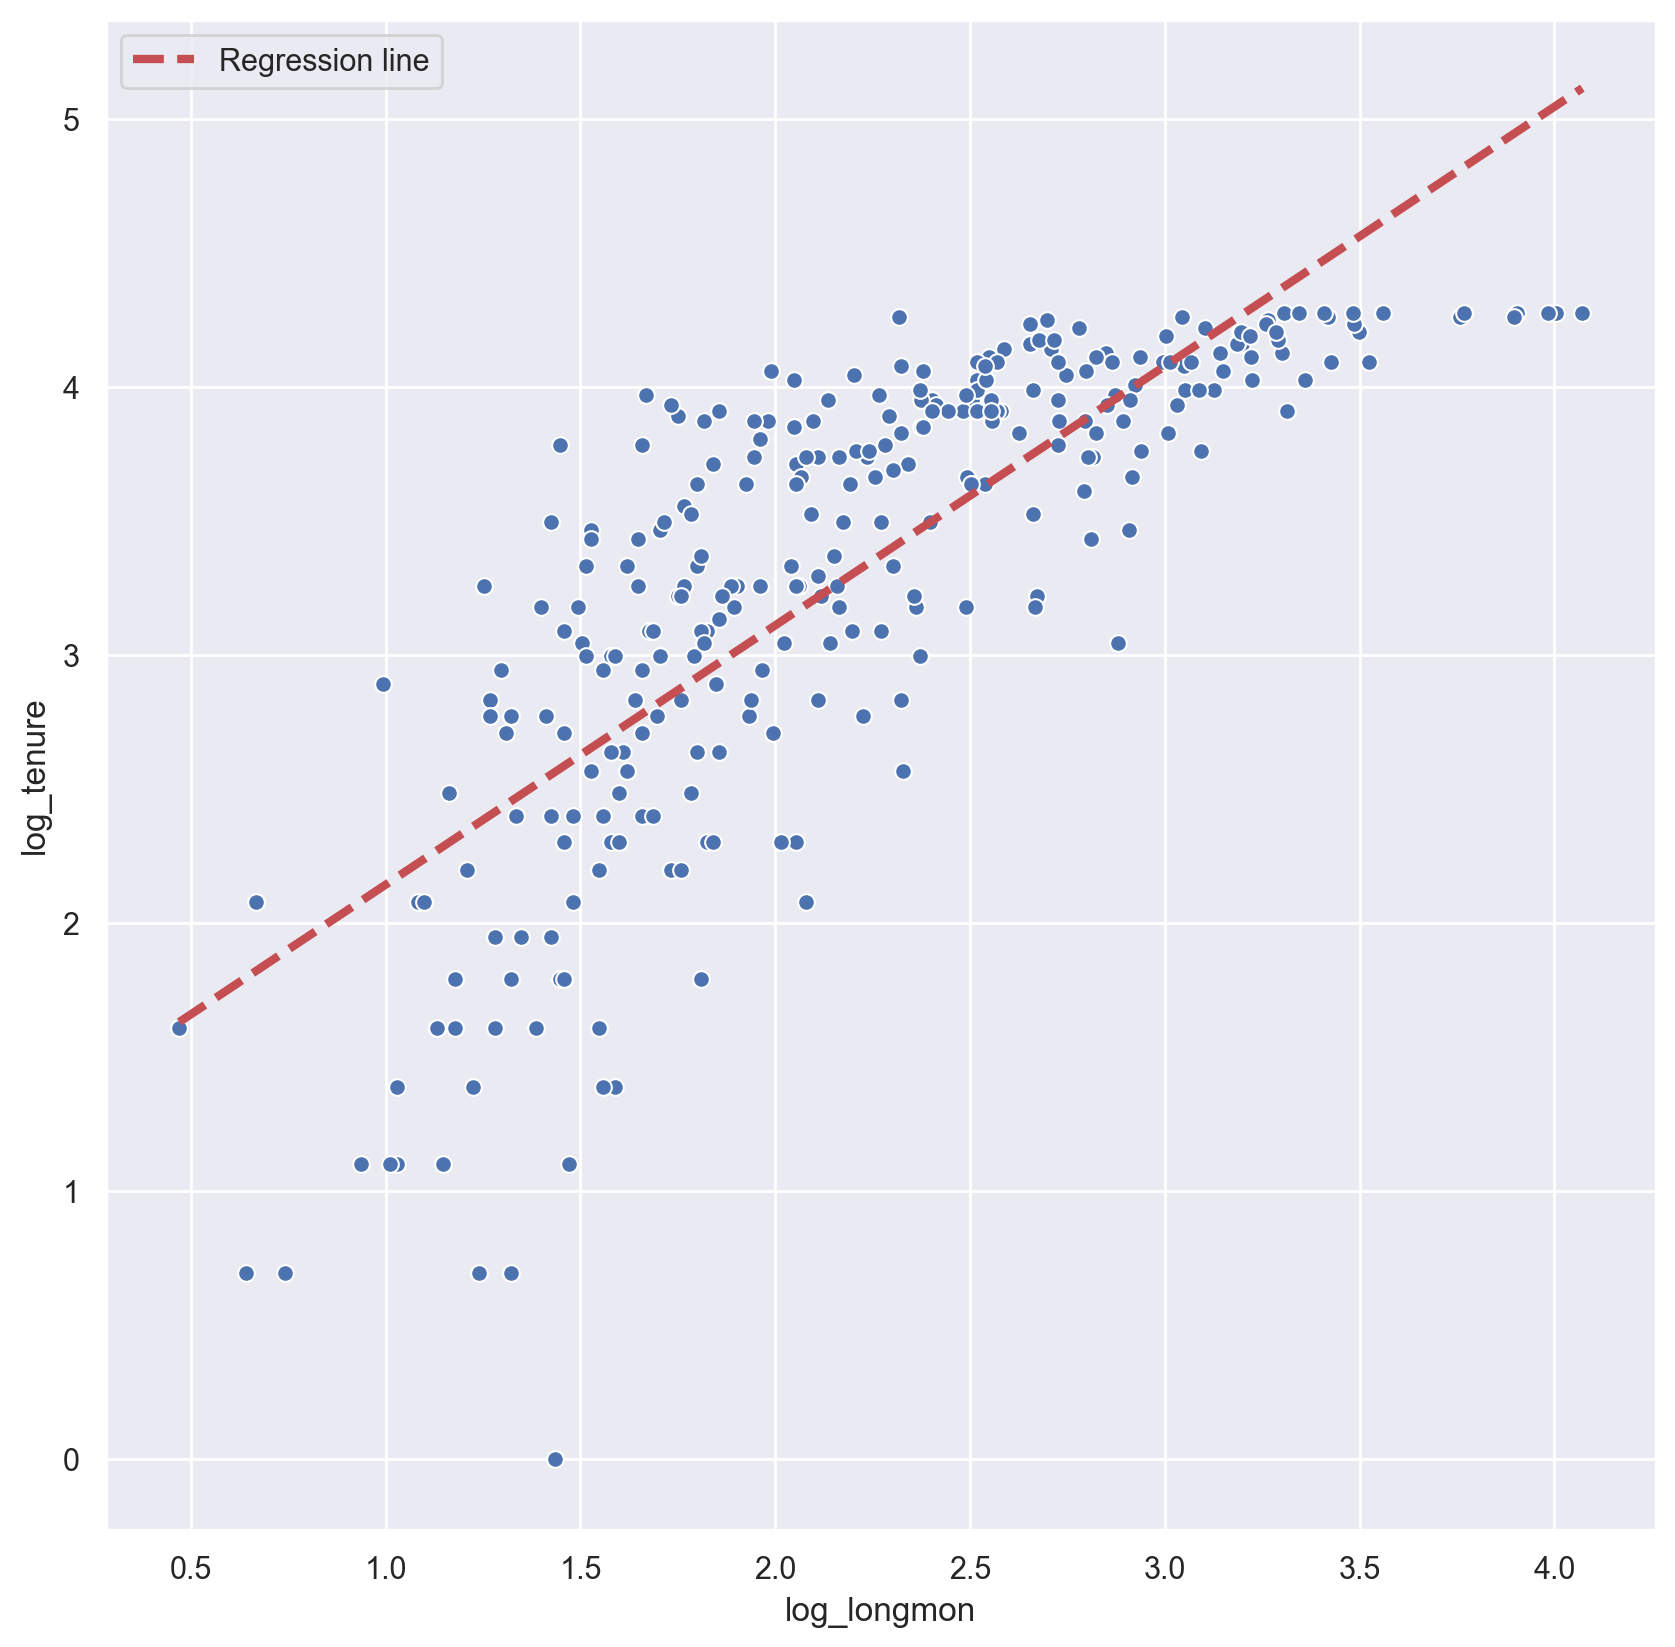

In [5]:
from sklearn.linear_model import LinearRegression

X_long = df['log_longmon'].values.reshape(-1, 1)
linreg = LinearRegression(fit_intercept=True).fit(X_long, y)

xx = np.linspace(X_long.min(), X_long.max(), 100)
yy = linreg.predict(xx.reshape(-1, 1))

plt.figure(dpi=200, figsize=(10, 10))
plt.plot(xx, yy, '--r', linewidth=3, label='Regression line')
plt.xlabel('$\log (longmon)$')
plt.ylabel('$tenure$')
sns.scatterplot(x='log_longmon', y=y, data=df)

2. Estimate now an appropriate nonlinear regression which might fit the data better. Add the regression curve to the plot and compare (quantitatively) the fit with the fit of the linear model.

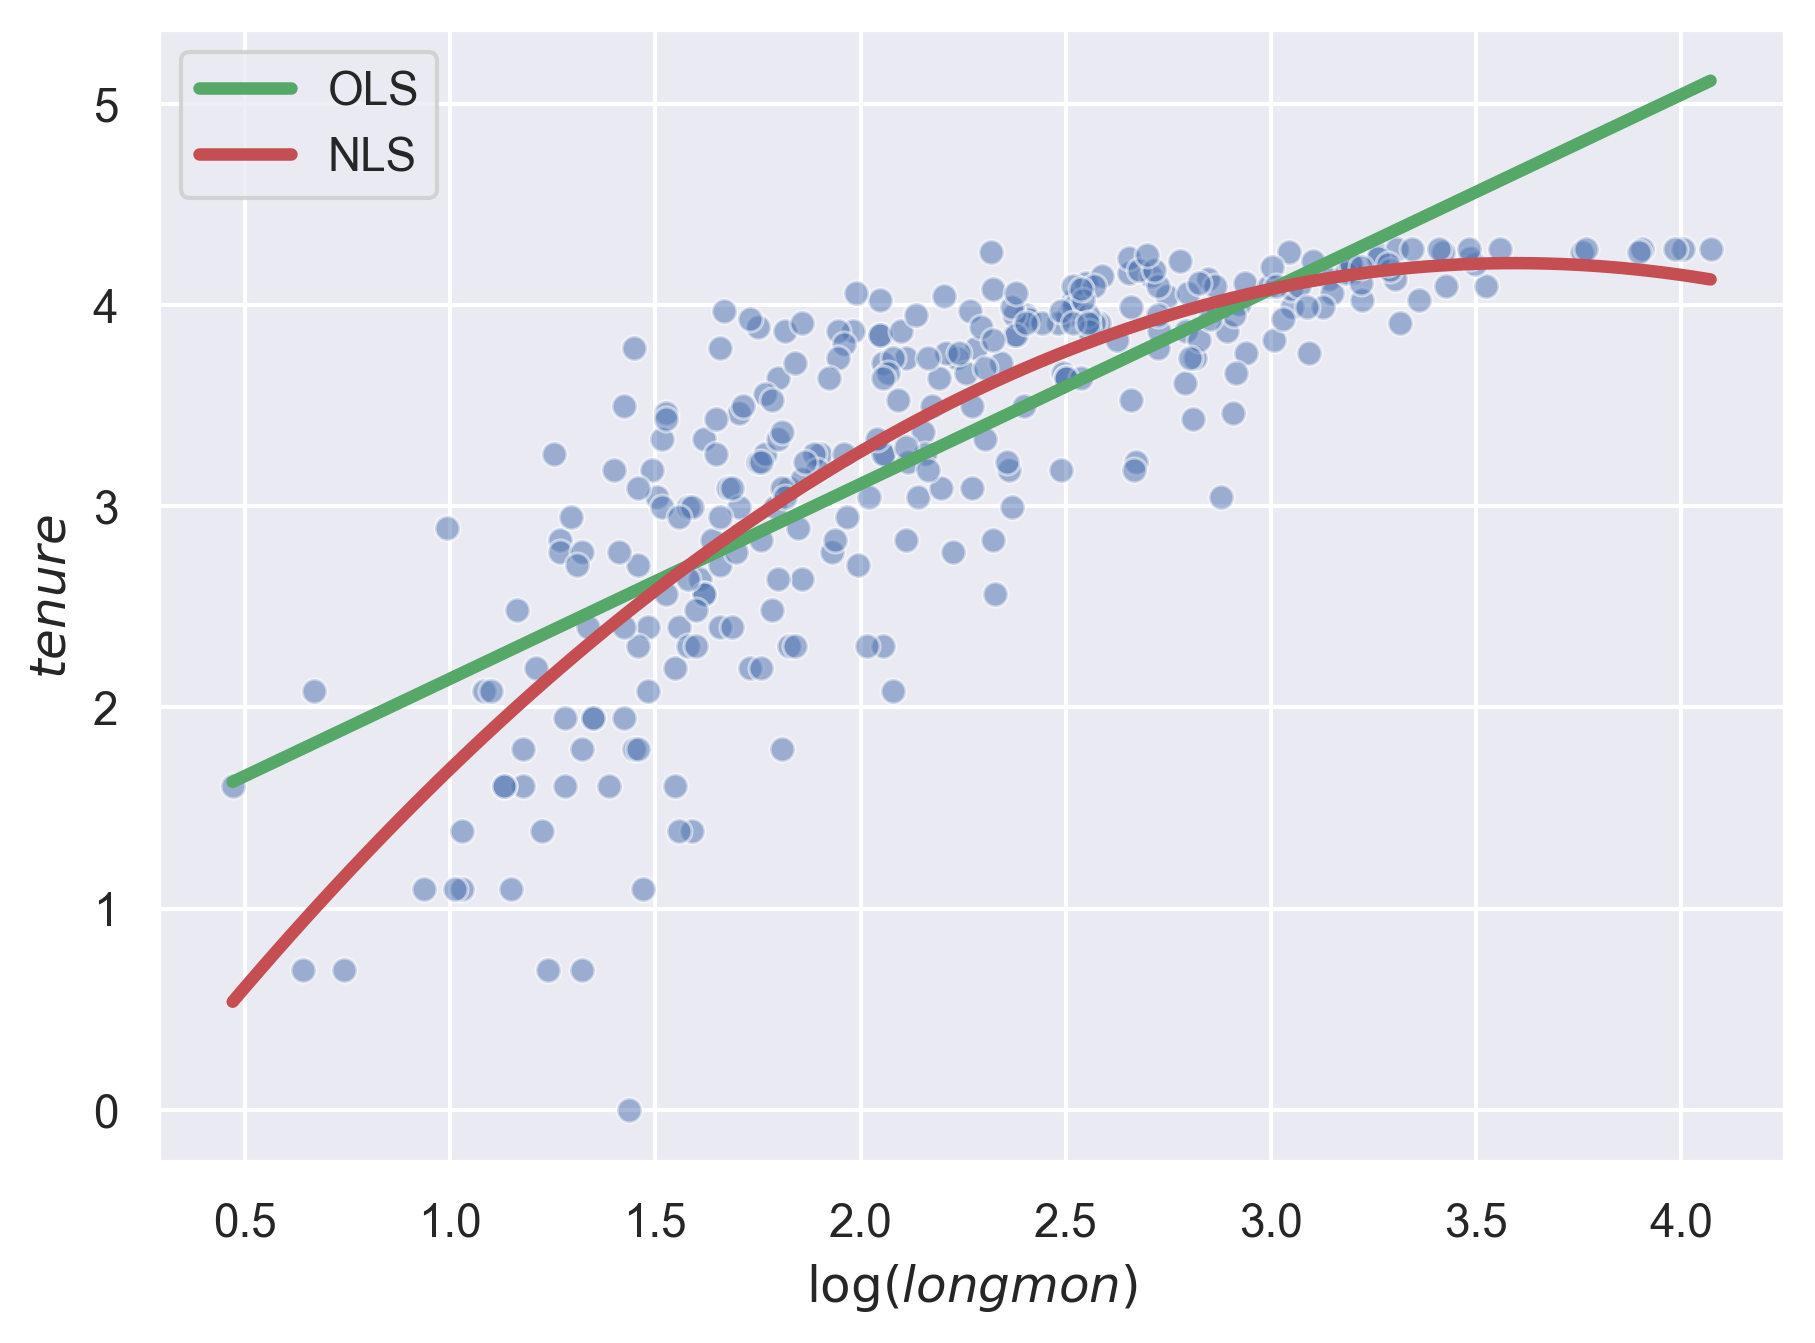

R^2 for OLS: 0.608, for NLS: 0.676


In [6]:
import lmfit

X_long = df['log_longmon']
y = y

def nls_func(x, a, b, c, d):
    return a + b * x + c * x**2 + d * x**3  

NLS = lmfit.Model(nls_func)
lm_result = NLS.fit(y, x=X_long, a=1., b=1., c=1., d=1.)

params = [v.value for v in lm_result.params.values()]

plt.figure(dpi=300, figsize=(7, 5))
sns.scatterplot(X_long, y, label=None, alpha=0.5)
sns.lineplot(xx, linreg.predict(xx.reshape(-1, 1)), c='g', linewidth=3, label='OLS')
sns.lineplot(xx, nls_func(xx, *params), c='r', linewidth=3, label='NLS')
plt.xlabel('$\log (longmon)$')
plt.ylabel('$tenure$')
plt.legend()
plt.show()

ols_y_pred = linreg.predict(X_long.values.reshape(-1, 1))
nls_y_pred = nls_func(X_long, *params)
print('R^2 for OLS: {:.3f}, for NLS: {:.3f}'.format(r2_score(y, ols_y_pred), r2_score(y, nls_y_pred)))


3. Explain in your own words, why all the classical tests and inferences are not directly applicable to the NLS estimators.

    Because classical test assume, that parameters are normally distributed. And that is not the case, when we use non linear estimators

4. What kind of problems might arise if we decide to fit a non-linear regression using all explanatory variables?

## Part 3: Nadaraya-Watson regression

> Next we model the relationship between __tenure__ and __address__ using the nonparametric Nadaraya-Watson regression.


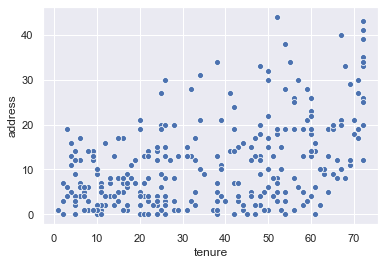

In [7]:
tenure = df['log_tenure']
address = df['address']

sns.scatterplot(df['tenure'], df['address'])

    1. An important calibration parameter of a nonparametric regression is the bandwidth. Explain what happens with the regression/the weights in the Nadaraya-Watson regression if the bandwidth is too high or too small.

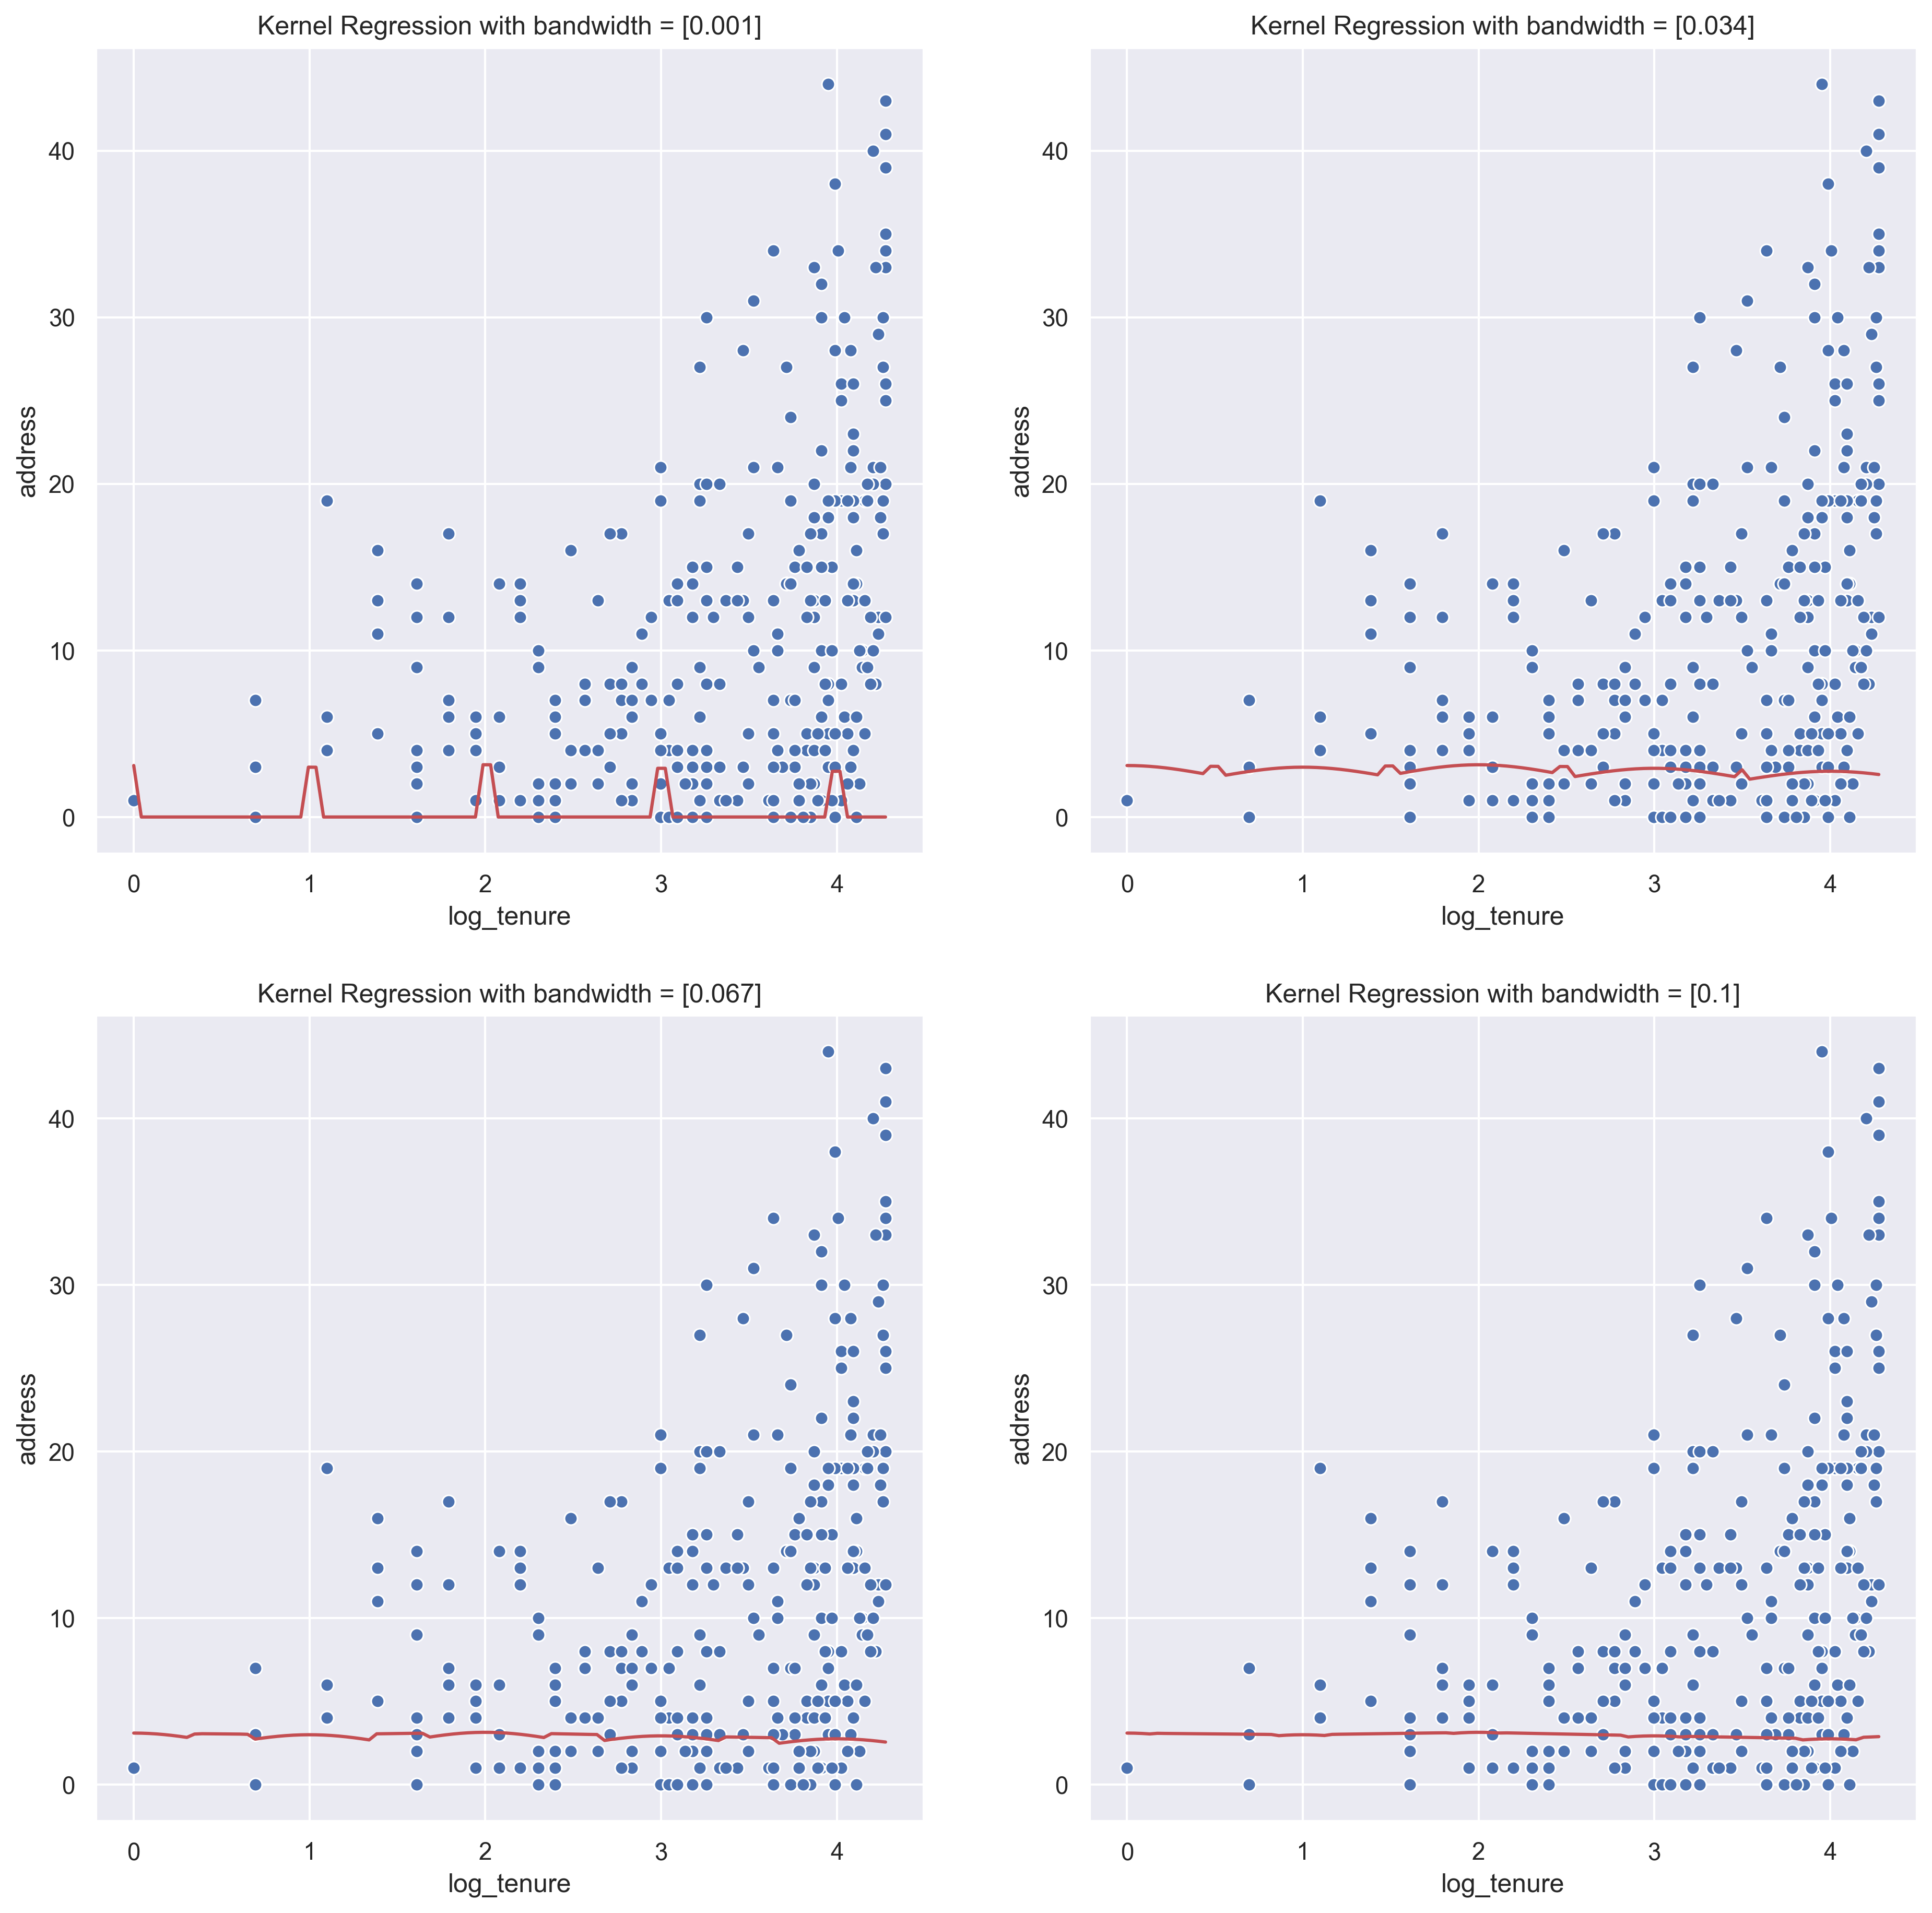

In [8]:
from statsmodels.nonparametric.kernel_regression import KernelReg

bandwidths = [[x] for x in np.linspace(0.001, .1, 4)]
xx = np.linspace(tenure.min(), tenure.max(), 100)

fig, axs = plt.subplots(nrows=2, ncols=2, dpi=300, figsize=(15, 15))
axs = axs.flatten()

for i, b in enumerate(bandwidths):
    kr = KernelReg(tenure, address, bw=b, var_type='c')
    mean, _ = kr.fit(xx)
    axs[i].set_title('Kernel Regression with bandwidth = {}'.format(b))
    sns.scatterplot(tenure, address, ax=axs[i])
    sns.lineplot(xx, mean, c='r', ax=axs[i])
plt.show()

    Bandwith is a smoothing parameter. The lower it is -- the noisier model will be. And vice versa.

    2. Fit a Nadaraya-Watson regression with Gaussian kernel and "optimal" bandwidth to the longmon/address data. Check and explain how the "optimal bandwidth" is determined in your software. Compare the (in-sample) fit of the nonparametric regression and the nonlinear regression in the previous subproblem.

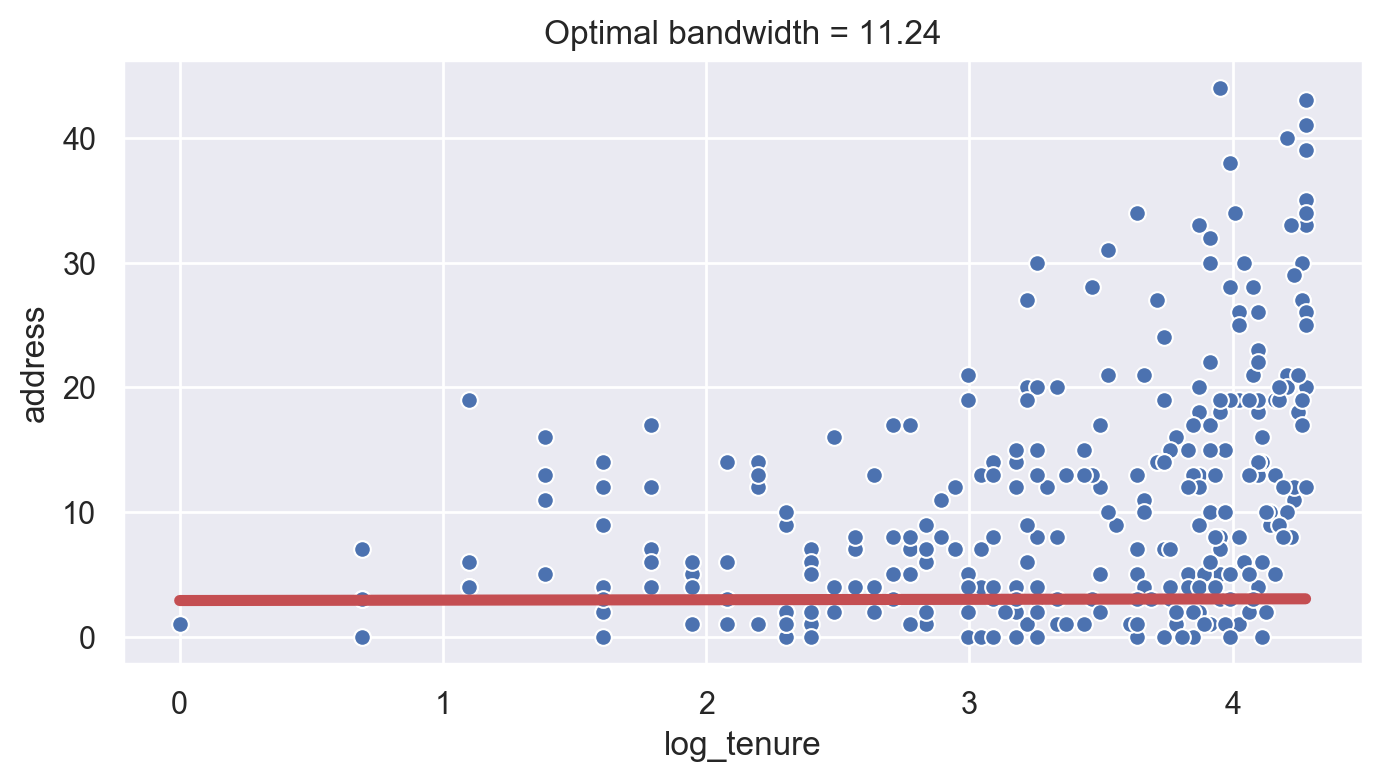

In [9]:
kr = KernelReg(tenure, address, bw='cv_ls', var_type='c')

xx = np.linspace(tenure.min(), tenure.max(), 100)
mean, _ = kr.fit(xx)

plt.figure(dpi=200, figsize=(8, 4))
sns.scatterplot(tenure, address)
sns.lineplot(xx, mean, c='r', linewidth=4)
plt.title('Optimal bandwidth = {:.2f}'.format(kr.bw[0]))
plt.show()

## Part 4: Logistic Regression

> Next we consider classification of the clients using the __churn__ variable as the dependent variable and the logistic regression.


    1. Fit a logistic regression to explain ((churn)) by the remaining explanatory variables.

In [158]:
from sklearn.linear_model import LogisticRegression

dependent_variable = 'churn'

explan_variables = [
    'age', 'marital', 'address', 'log_income',
    'employ', 'retire','gender', 'log_longmon',
    'wiremon', 'ed_college', 'log_tenure',
    'ed_high', 'ed_undergrad', 'ed_some_college'
]

seed = 42

X, y = df[explan_variables], df[dependent_variable] 

logreg = LogisticRegression(random_state=0).fit(sm.add_constant(X), y)

logreg.score(sm.add_constant(X), y)

0.7263513513513513

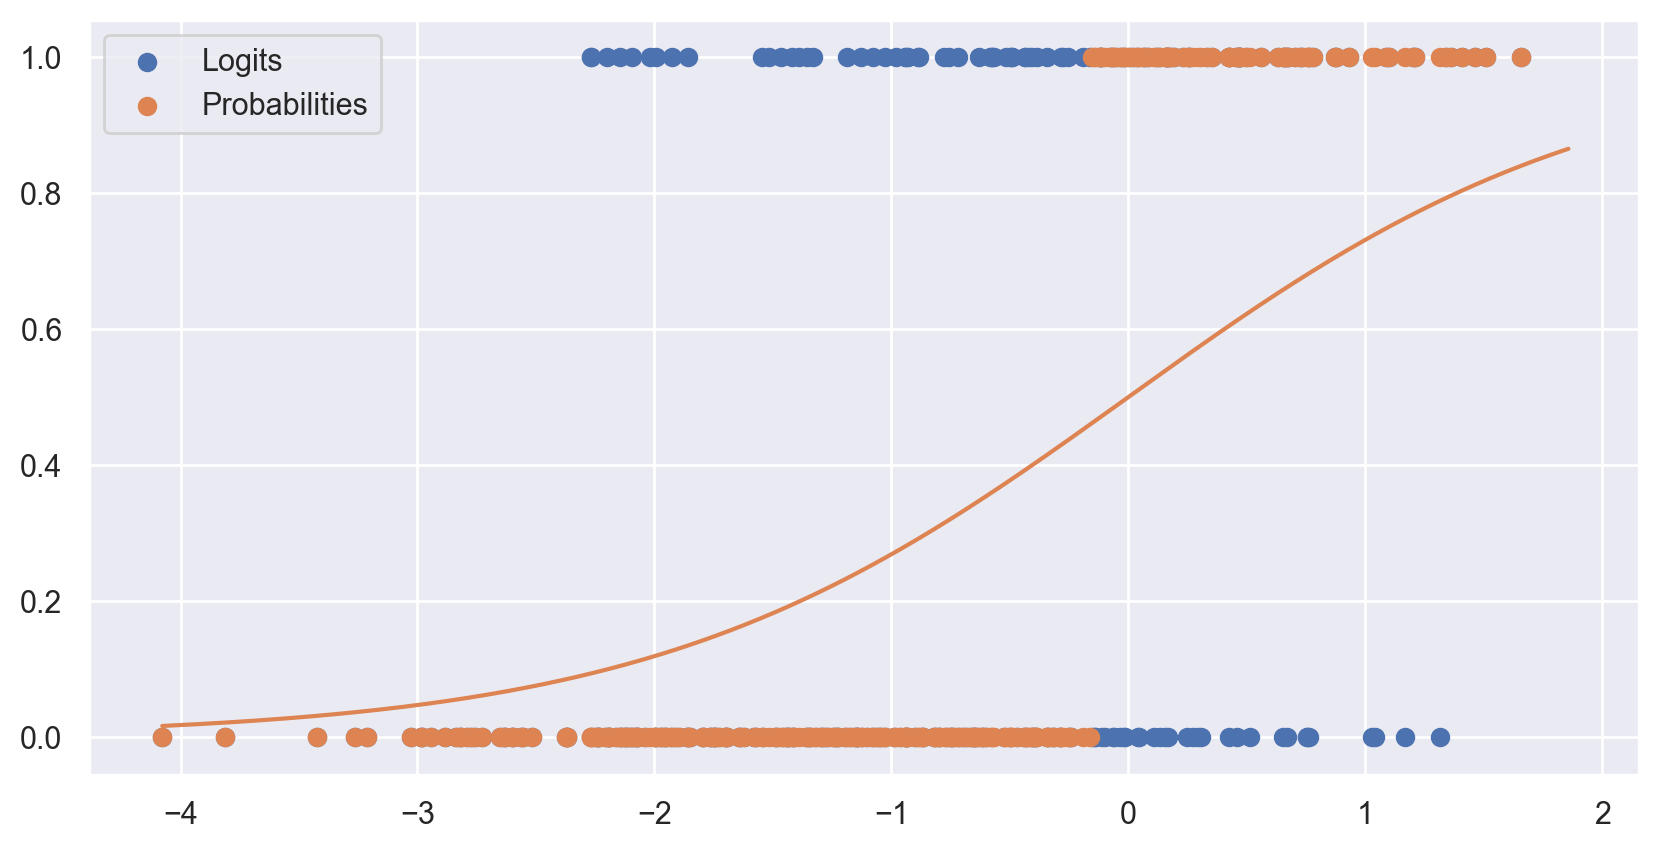

In [47]:
logits = np.dot(sm.add_constant(X), logreg.coef_.T)

probs = logreg.predict(sm.add_constant(X))

t = np.linspace(logits.min(), logits.max() + .2, 500)

plt.figure(figsize=(10, 5), dpi=200)
plt.scatter(logits, y, label='Logits')
plt.scatter(logits, probs, label='Probabilities')
plt.legend()
plt.plot(t, 1./(1. + np.exp(-t)), 'C1')
plt.show()

    2. Consider the explanatory variable ((tenure)). Obviously its parameter cannot be interpreted in the same way as for a linear regression. Provide the correct interpretation using the parameter and using odds.

    3. Run a stepwise model selection using AIC as criterion. Further consider only the optimal model chosen here. From the final model, which of the variables do increase the probability of churn and which variables decrease this probability? Is this consistent with economic intuition?

In [160]:
def aic(y, y_h, K):
    N = len(y)
    u = y - y_h
    s2 = np.var(u, ddof=1)
    
    aic = np.log(s2) + 2.* K / N
    
    return aic

X, y = df[explan_variables], df[dependent_variable]

reg_all = explan_variables.copy()
reg_selected = []
scores_selected = []

max_score = np.inf
score = np.inf

while score is max_score and bool(reg_all):
    reg_score = []
    
    for regr in reg_all:
        X_ = X.loc[:, reg_selected + [regr]]
        X_ = sm.add_constant(X_)
        y_h = sm.Logit(y, X_).fit(disp=False).predict(X_);
        s = aic(y, y_h, len(X_))
        reg_score.append(s)
    
    i = np.argmin(reg_score)
    score = reg_score[i]
    
    if score < max_score:
        max_score = score
        reg_selected.append(reg_all[i])
        scores_selected.append(score)
        del reg_all[i]

for i in range(len(reg_selected)):
    print('{}: {:.3f}'.format(reg_selected[i], scores_selected[i]))

X, y = df[reg_selected], df[dependent_variable]

X_ = sm.add_constant(X)

logreg = sm.Logit(y, X_).fit()
logreg.summary()

log_tenure: 0.368
employ: 0.353
log_income: 0.329
wiremon: 0.322
address: 0.315
log_longmon: 0.311
ed_undergrad: 0.309
ed_college: 0.303
ed_some_college: 0.301
ed_high: 0.291
retire: 0.290
gender: 0.290
Optimization terminated successfully.
         Current function value: 0.537858
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                  296
Model:                          Logit   Df Residuals:                      283
Method:                           MLE   Df Model:                           12
Date:                Sat, 01 Feb 2020   Pseudo R-squ.:                  0.1803
Time:                        13:36:43   Log-Likelihood:                -159.21
converged:                       True   LL-Null:                       -194.23
Covariance Type:            nonrobust   LLR p-value:                 3.150e-10
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1063      1.231     -0.086      0.931      -2.518       2.306
log_tenure         -0.6838      0.260     -2.626      0.009      -1.194      -0.173
employ             -0.0402      0.026     -1.568      0.117      -0.090       0.010
log_income          0.3626      0.253      1.434      0.151      -0.133       0.858
wiremon             0.0127      0.010      1.288      0.198      -0.007       0.032
address            -0.0242      0.019     -1.277      0.202      -0.061       0.013
log_longmon        -0.5194      0.347     -1.495      0.135      -1.200       0.161
ed_undergrad        1.7864      0.968      1.845      0.065      -0.112       3.685
ed_college          1.6536      0.901      1.835      0.066      -0.112       3.420
ed_some_college     1.4076      0.911      1.546      0.122      -0.377       3.192
ed_high             1.2543      0.914      1.373      0.170      -0.537       3.045
retire              0.5619      1.211      0.464      0.643      -1.811       2.935
gender              0.0266      0.277      0.096      0.923      -0.515       0.569
===================================================================================
"""

4. Randomly pick up five clients. Determine their probabilities of leaving the company. Provide for the first of them the formula which may be used to compute this probability with inserted values of parameters and variables. If you want to predict the membership in one of the two groups for a particular client, what is the simplest way to proceed using these probabilities?

In [117]:
random_clients = np.random.choice(df.index, 5)
predictions = logreg.predict(X_.loc[random_clients]).reset_index()[0]

for i in range(len(random_clients)):
    print('Client ID [{}] will leave company with {:.2f}% confidence'
          .format(random_clients[i], predictions[i]))

Client ID [724] will leave company with 0.64% confidence
Client ID [70] will leave company with 0.73% confidence
Client ID [143] will leave company with 0.54% confidence
Client ID [445] will leave company with 0.19% confidence
Client ID [633] will leave company with 0.43% confidence


To predict, that client X is in the group 1:

$$p(y = 1| X) = \frac{1}{1 + e^{- \beta^\top X}}$$

To classify a client, we have to introduce some threshold. If we use threshold of 0.5, and want our client to be in the first group, then:

$$\frac{1}{1 + e^{- \beta^\top X}} > 0.5$$

5. Compute the classification table and calculate the specificity and sensitivity. Provide verbal interpretation for the elements of the classification table and the performance measures.

In [123]:
cl_table = logreg.pred_table(0.5)
cl_table_prob = cl_table / cl_table.sum(1)

In [136]:
TP, FP, FN, TN = cl_table.flatten()
print('True Positive {}'.format(TP))
print('True Negative {}'.format(TN))
print('False Negative {}'.format(FN))
print('False Positive {}'.format(FP))

print('Sensitivity {:.3f}'.format(TP / (TP + FN)))
print('Specifity {:.3f}'.format(TN / (FP + TN)))

True Positive 157.0
True Negative 57.0
False Negative 51.0
False Positive 31.0
Sensitivity 0.755
Specifity 0.648


    True Positive -- number of class hit
    True Negative -- number of correct rejections
    False Positive -- number of false alarms
    False Negative -- number of misses
    Sensitivity -- percentage of people, who are correctly indentified as those, who left job
    Specificity -- percentage of people, who did not left job and correctly identified
    

6. To improve the performance it makes sense to change the threshold used for classification. This can be done using the ROC curve. Plot this curve and determine the optimal threshold.

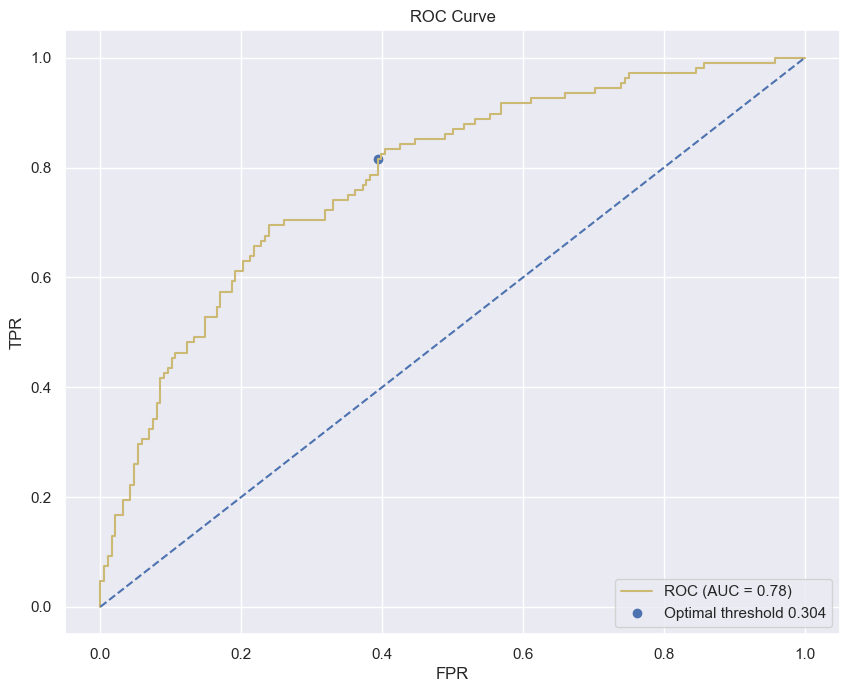

In [333]:
from sklearn.metrics import roc_curve, auc

def compute_roc(y_true, y_pred, plot=False):
    fpr, tpr, th = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    
    idx_best = (tpr > 0.8).argmax()
    optimal_th = th[idx_best]
    if plot:
        plt.figure(figsize=(10, 8), dpi=100)
        plt.scatter(fpr[idx_best], tpr[idx_best], label='Optimal threshold {:.3f}'.format(th[idx_best]))
        plt.plot(fpr, tpr, color='y',
                 label='ROC (AUC = %0.2f)' % auc_score)
        plt.legend(loc='lower right')
        plt.title("ROC Curve")
        plt.plot((0., 1.), (0., 1.), '--b')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

    return fpr, tpr, th, auc_score 
    
y_pred = logreg.predict(X_)
fpr, tpr, th, auc_score  = compute_roc(y, y_pred, True)

7. Recompute the classification table, sensitivity and specificity for the new threshold. Provide interpretation of the obtained values. Compare the results with the original values. Is the procedure now more strict/conservative?

In [336]:
optimal_th = th[(tpr > 0.8).argmax()]
logreg.pred_table(optimal_th)

TP, FP, FN, TN = cl_table.flatten()
print('True Positive {}'.format(TP))
print('True Negative {}'.format(TN))
print('False Negative {}'.format(FN))
print('False Positive {}'.format(FP))

print('Sensitivity {:.3f}'.format(TP / (TP + FN)))
print('Specifity {:.3f}'.format(TN / (FP + TN)))

True Positive 157.0
True Negative 57.0
False Negative 51.0
False Positive 31.0
Sensitivity 0.755
Specifity 0.648


## Problem 5: Regression Trees

> In the next step we model __tenure__ using regression trees.

    1. Assume the first variable to be used for splitting is ((longmon)). Write down the corresponding optimization problem and explain how the optimization works.

Suppose we have training vectors $x_i \in \mathbb{R^n}$, $i=\overline{1, m}$ and a label vector $y \in \mathbb{R^m}$.

Let the data at current node $j$ be represented by $Q$. For each candidate split $\theta = (j, t_m)$ consisting of a feature $j$ and threshold $t_m$, partition the data into $Q_{left}(\theta)$ and $Q_{right}(\theta)$ subsets

$$Q_{left}(\theta) = (x, y) | x_j \le t_m$$
$$Q_{right}(\theta) = Q \backslash Q_{left} (\theta)$$

The impurity at $m$ is computed using an impurity function $H(Q) = \frac{1}{N_Q} \sum_{i} (y_i - \overline{y})^2$

$$G(Q, \theta) = \frac{n_{left}}{N_m} H(Q_{left}(\theta)) + \frac{n_{right}}{N_m} H(Q_{right}(\theta))$$

We select parameter, that minimises the impurity

$$\theta^* = \text{argmin}_{\theta} G(Q, \theta)$$

By minimizing $G$ we can choose the best split (with the smallest impurity lvl)

    2. Obviously you can get very long trees. Tree prunning helps to get trees of a reasonable size. Fit a CART to the data and prune it to have at most 10 splits. What is the value of the corresponding complexity parameter? Check you software for the implementation of the prunning, particularly the form of the loss function.
    
> complexity level is a **max_leaf_nodes**

In [345]:
from sklearn.tree import DecisionTreeRegressor as DTR

X, y = df[reg_selected], df[dependent_variable]

tree = DTR(max_leaf_nodes=10).fit(X, y)

r2_score = tree.score(X, y)

print('R^2 score = {:.3f}'.format(r2_score))

R^2 score = 0.344


    3. Check the value of the improvement in the first split. Explain the idea of improvement and provide numerical expression how this improvement is computed for the first split.

$$MSE_i = \frac{1}{K_i} \sum^{K_i}_{k=1}(y_k - \overline{y}_{Node_i})^2$$

$$\text{Improvement} = \frac{MSE_1 * K_1 - [MSE_2 * K_2 + MSE_3 * K_3]}{MSE_1 * K_1}$$

In [414]:
K_1 = X.shape[0]
MSE_1 = 1./K_1 * np.sum((y - np.mean(y))**2)

node_2 = y[X.iloc[:, 0] <= threshold[0]]
K_2 = node_2.shape[0]

node_3 = y[X.iloc[:, 0] > threshold[0]]
K_3 = node_3.shape[0]

MSE_2 = 1./K_2 * np.sum((node_2 - np.mean(node_2))**2)
MSE_3 = 1./K_3 * np.sum((node_3 - np.mean(node_3))**2)

improvement = (MSE_1 * K_1 - MSE_2 * K_2 + MSE_3 * K_3)/(MSE_1 * K_1)

print('Improvement is {:.2f}'.format(improvement))

Improvement is 1.29


    4. Compare the in-sample fit of the tree to the in-sample fit of the lasso regression above. Compare the importance of the variables for the two models. In the case of the lasso regression the importance is mirrored by the parameters if the variables are standardized.

In [386]:
from sklearn.linear_model import Lasso

X, y = df[reg_selected], df[dependent_variable]

lreg = Lasso(alpha=0.01).fit(X, y)
tree = DTR(max_leaf_nodes=10).fit(X, y)

print('Lasso R^2: {:.3f}'.format(lreg.score(X,y)))
lfimp = (np.abs(lreg.coef_) / np.abs(lreg.coef_).sum()).round(2)
print('Lasso features importances \n', lfimp)

print('Tree R^2: {:.3f}'.format(tree.score(X,y)))
print('Tree features importances \n', tree.feature_importances_.round(2))


Lasso R^2: 0.197
Lasso features importances 
 [0.57 0.03 0.2  0.01 0.01 0.16 0.   0.03 0.   0.   0.   0.  ]
Tree R^2: 0.344
Tree features importances 
 [0.44 0.   0.   0.17 0.13 0.2  0.   0.07 0.   0.   0.   0.  ]
